### 三、投资策略

#### 2、配置策略：风险平价（Risk Parity）模型

风险平价（Risk Parity）理论是当代资产配置理论中的一种，该理论是先出现在金融市场实践，再被发展成理论的：早在1996年，桥水基金（Bridgewater Associates）就推出了应用该策略的产品，也就是后来大名鼎鼎的“全天候策略基金”（All weather strategy fund）。2005年，PanAgora Asset Management的CIO和研究主管Edward Qian博士发表了文章《On the Financial Interpretation of Risk: Risk Budgets do add up》，被广泛认为是“风险平价”概念的第一次正式提出和构建方式的数理化。

对于投资组合，其收益率和风险，可按以下公式表示：
$$r_{p}= \sum_{i=1}^{n} w_{i} \cdot r_{i}$$
$$\sigma_{p}= \sqrt {\sum_{i=1}^{n}  \sum_{j=1}^{n} w_{i} \cdot w_{j} \cdot \sigma_{ij}}$$

单个资产对投资组合的风险贡献，以MC表示，计算如下：
$$MC_{i}=w_{i} \cdot \frac{\sum_{j=1}^{n} w_{j} \cdot \sigma_{ij}}{\sigma_{p}}$$
$$\sigma_{p}=\sum_{i=1}^{n} MC_{i}$$

在确定每个资产风险权重后，可计算每个资产在投资组合里的配置权重。

#### 3、策略实施步骤

1）期初：根据前一周及之前的数据，计算各资产的Cov矩阵，并按风险平价模型，计算各资产的理论权重，为避免资产权重波动太大，对理论权重进行平滑处理；

2）期间：根据理论权重，计算除SHY以外的各资产应增加或减少的份额，以及所需资金或结余资金，如需资金以出售SHY份额解决，如结余资金则购买SHY份额；

3）期末：根据建仓成本和份额，计算投资组合的估值，及各资产的实际权重。

最后，按月、年，计算当期的投资收益、最大回撤，并与Benchmark进行比较。

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import datetime
import pandas as pd
import numpy as np
import itertools

In [4]:
# set end_date
end_date = '2018-12-31'
comparable_ticker = 'SPY'
mc_budget = [0.1, 0.5, 0.2, 0.2]

In [9]:
# 读取数据
etf_tickers=['SHY','SPY','XLE','XLF']
pl=read_csv(etf_tickers, end_date)
portfolio = 'Protfolio'
#周线
wp = pl.resample('W', loffset=pd.offsets.timedelta(days=-6)).mean().dropna()

In [20]:
hist_p = wp[wp.index.year<=2003]

In [23]:
last_shares = np.zeros(len(hist_p.columns))
last_cash = 1000000
per, s, w = get_performance(hist_p, mc_budget, last_shares, last_cash)

SHY    0.005370
SPY    0.107159
XLE    0.082525
XLF    0.105278
Name: 2003-08-25 00:00:00, dtype: float64 SHY    0.033634
SPY    0.142806
XLE    0.116661
XLF    0.164225
Name: 2003-08-25 00:00:00, dtype: float64
SHY    0.006346
SPY    0.132365
XLE    0.098554
XLF    0.125295
Name: 2003-09-01 00:00:00, dtype: float64 SHY    0.033302
SPY    0.141541
XLE    0.113530
XLF    0.150936
Name: 2003-09-01 00:00:00, dtype: float64
SHY    0.009652
SPY    0.124395
XLE    0.089622
XLF    0.114045
Name: 2003-09-08 00:00:00, dtype: float64 SHY    0.033113
SPY    0.158060
XLE    0.130140
XLF    0.156347
Name: 2003-09-08 00:00:00, dtype: float64
SHY    0.010587
SPY    0.129635
XLE    0.069288
XLF    0.127228
Name: 2003-09-15 00:00:00, dtype: float64 SHY    0.033319
SPY    0.202602
XLE    0.156514
XLF    0.193683
Name: 2003-09-15 00:00:00, dtype: float64
SHY    0.010713
SPY    0.105706
XLE    0.067562
XLF    0.114859
Name: 2003-09-22 00:00:00, dtype: float64 SHY    0.034380
SPY    0.246319
XLE    0.18555

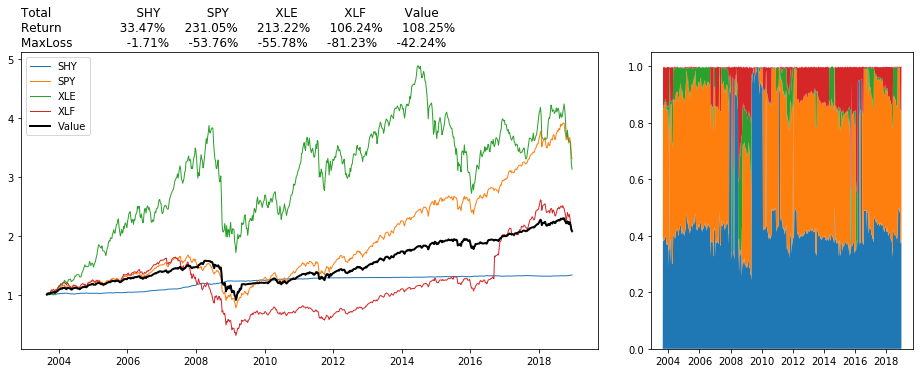

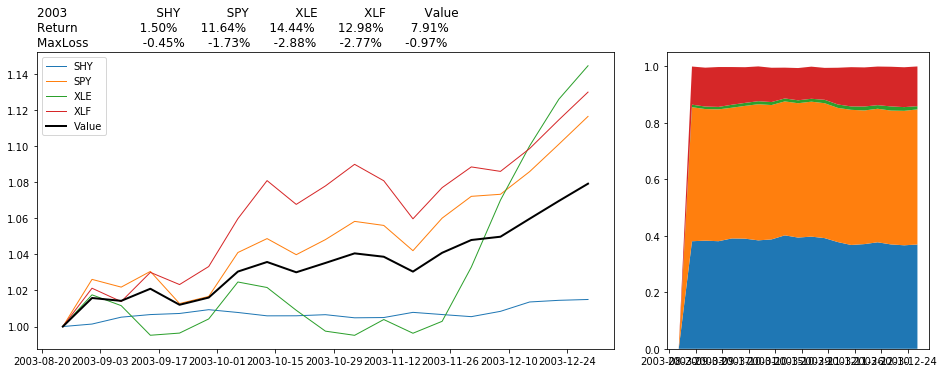

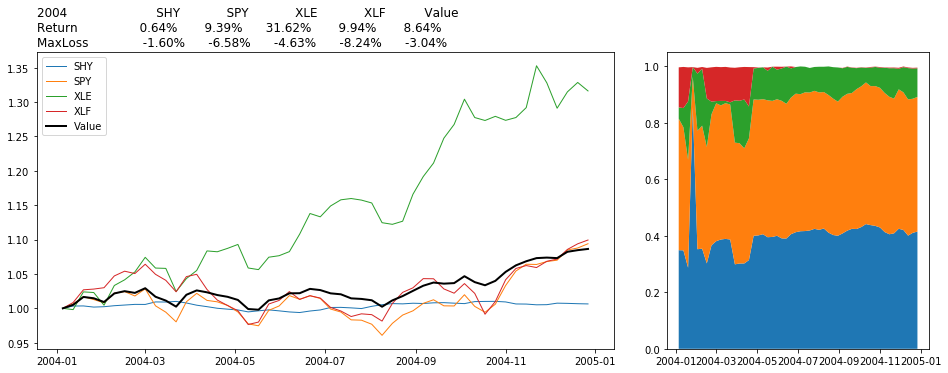

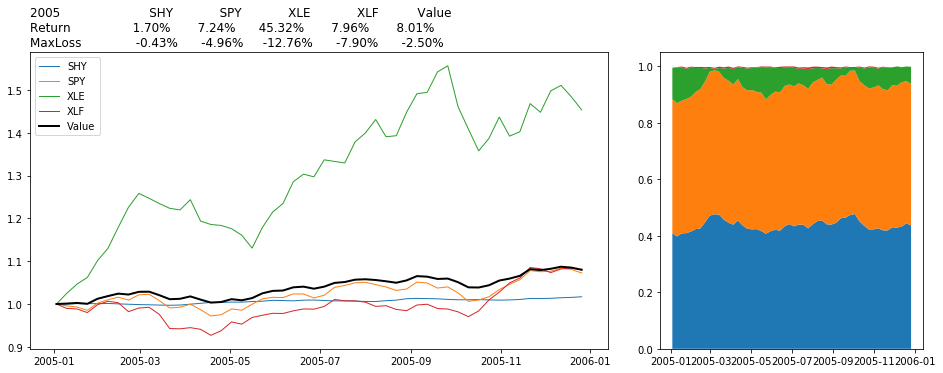

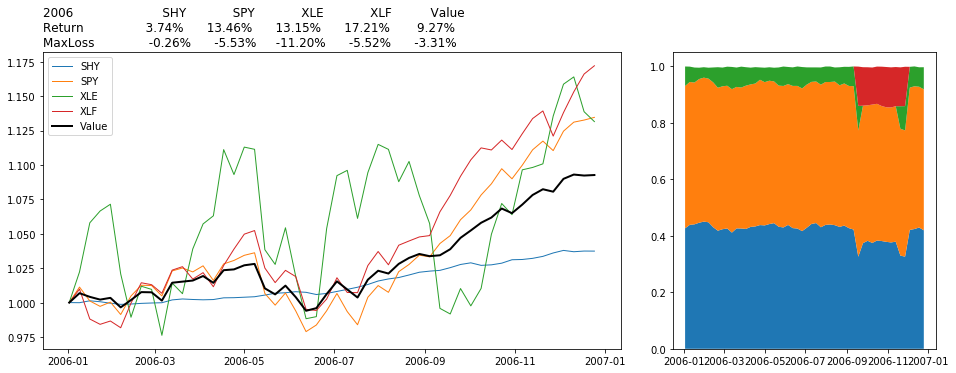

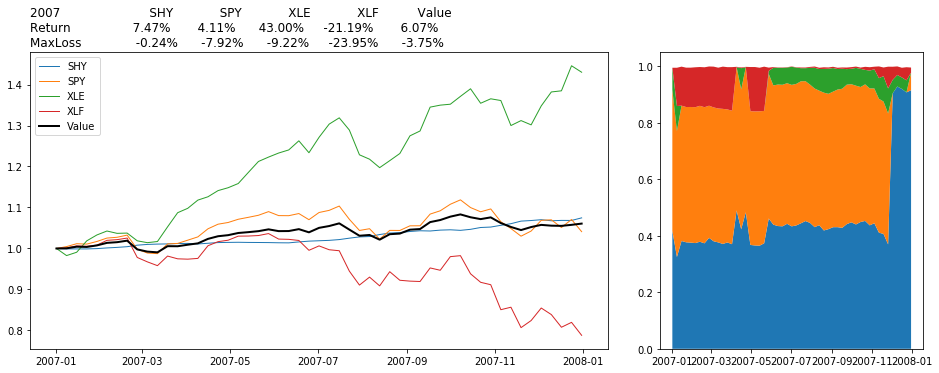

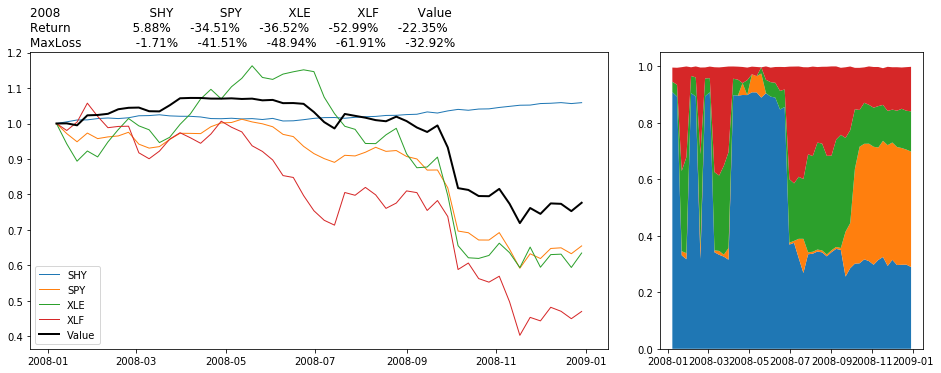

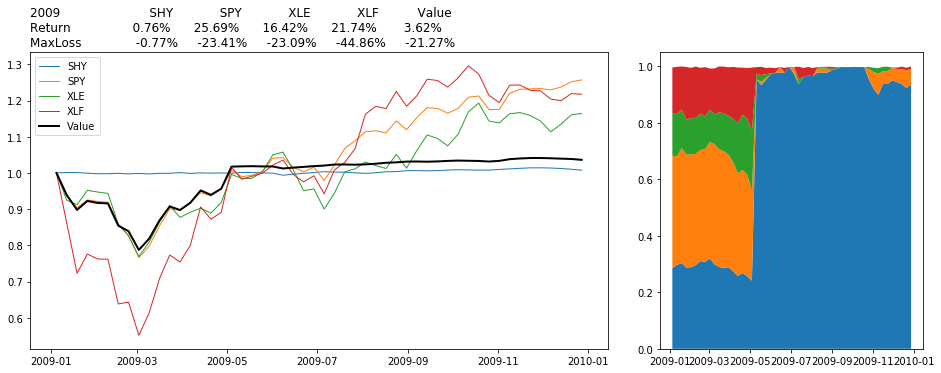

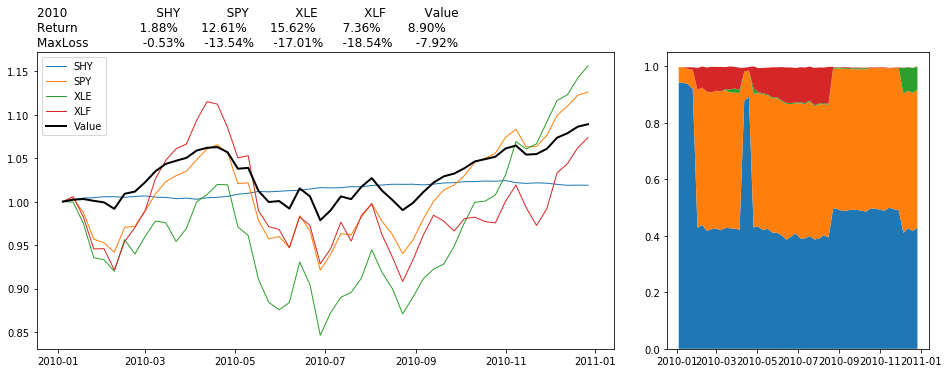

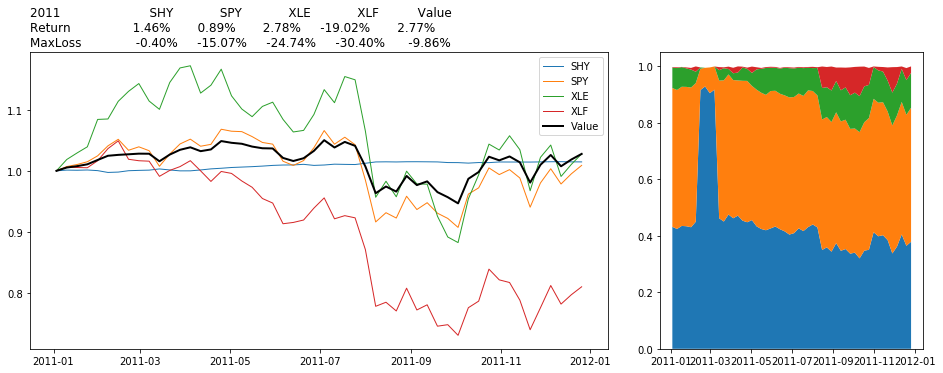

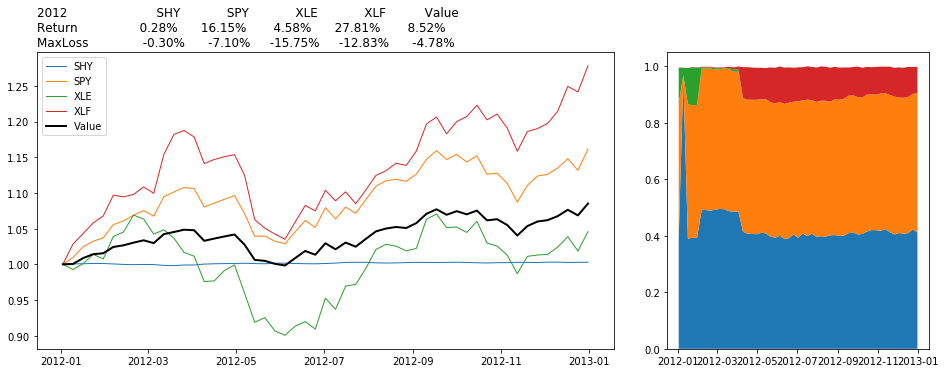

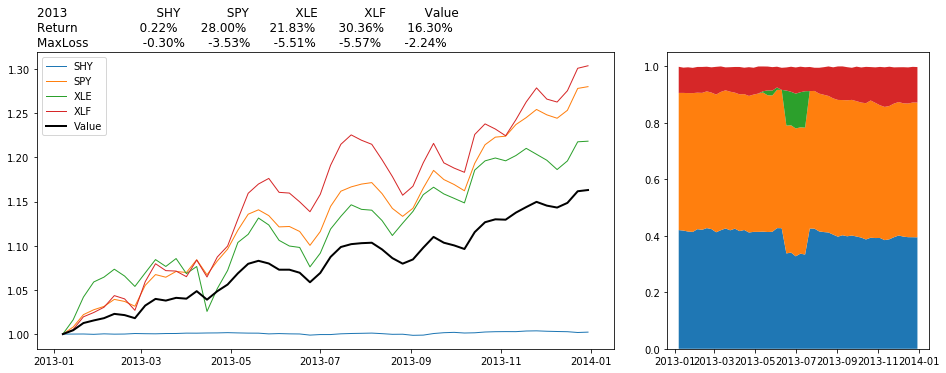

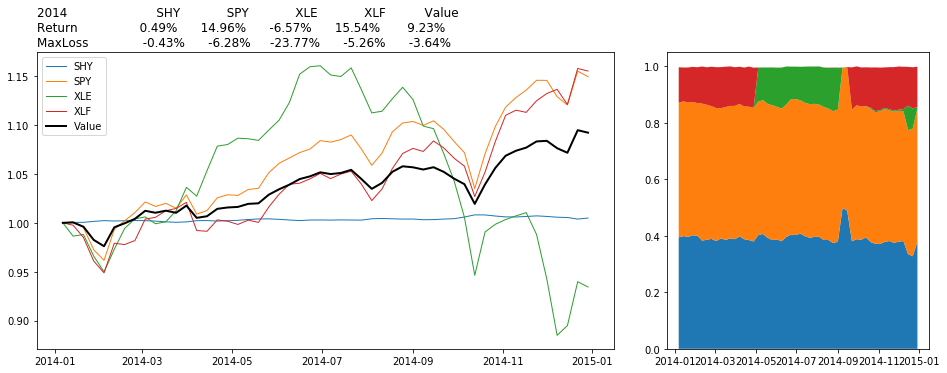

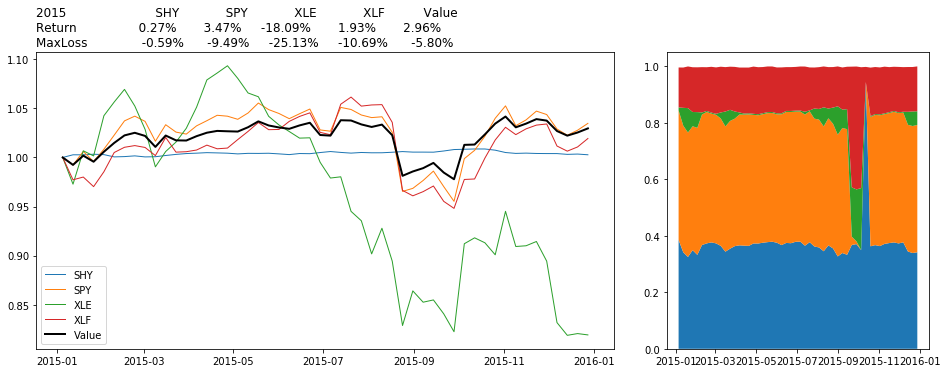

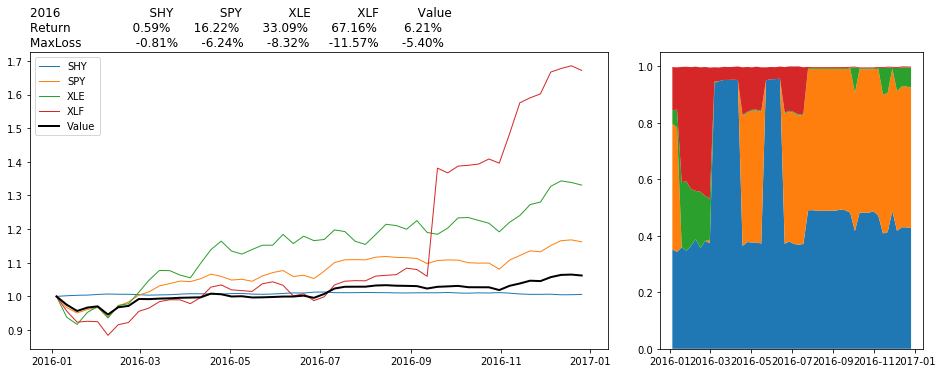

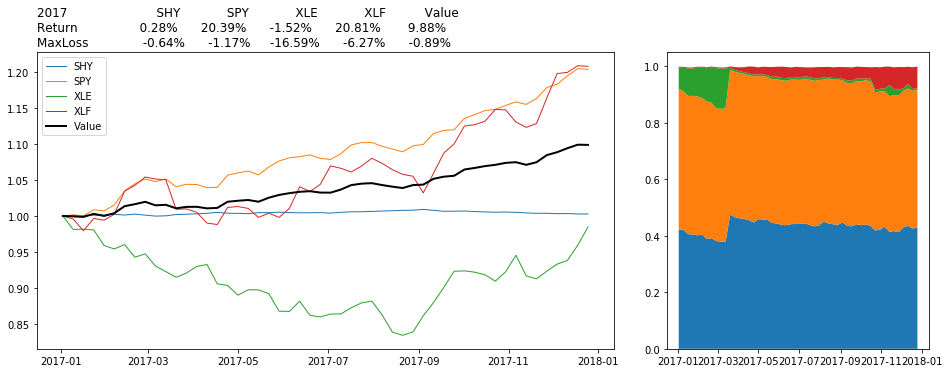

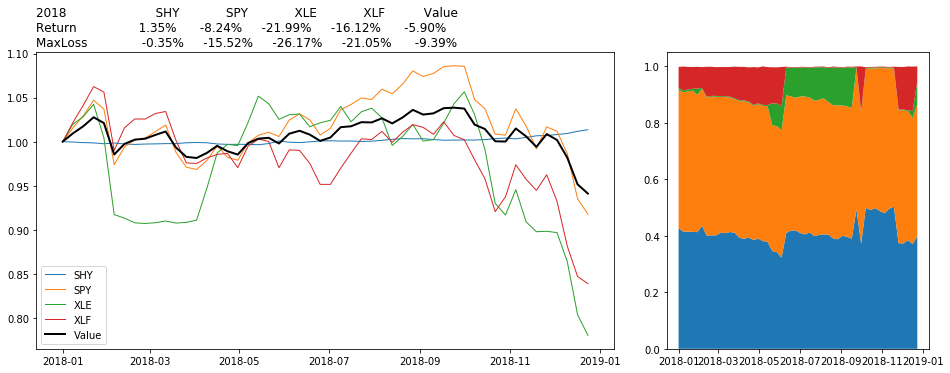

In [18]:
nr, totalreturn, std, maxloss = get_results(per)
plot_performance(nr, w, totalreturn, std, maxloss)
# slipt date by year
for k,g in itertools.groupby(per.index.year):
    pery=per[per.index.year==k]
    wy=w[w.index.year==k]
    nry, totalreturny, stdy, maxlossy = get_results(pery)
    plot_performance(nry, wy, totalreturny, stdy, maxlossy, k)

In [2]:
def get_shares(last_p, mc_budget, last_shares, last_cash, is_smooth_w=0, mp=52, dw=5): #is_smooth_w=1 is smooth and if less than, not smooth
    if len(last_p) >= mp+dw:
        p = last_p[len(last_p)-mp-dw:len(last_p)] #[0:57=52+5]
        w = get_w(p, mc_budget, mp, dw)
        shares, cash = get_s(p.iloc[-1], w, last_shares, last_cash, is_smooth_w)
    else:
        print('Not Enough Historical Data to Calc Weights') 
        shares = last_shares
        cash = last_cash
    return shares, cash

def real_w(p, v, s):
    w = np.zeros(len(p))
    for e in range(0,len(p)):
        w[e] = s[e]*p[e] / v
    return w

def smooth_w(w, last_w, smooth_factor=0.05):
    w[0] = 1.0
    for e in range(1,len(w)):
        if w[e]/last_w[e]>1+smooth_factor:
            w[e]=last_w[e]*(1+smooth_factor)
        elif w[e]/last_w[e]<1-smooth_factor:
            w[e]=last_w[e]*(1-smooth_factor)
        w[0]=w[0]-w[e]
    return w
    
def get_s(p, w, last_shares, last_cash, is_smooth_w):
    nShare = 100
    shares = last_shares
    last_v = p.dot(last_shares) + last_cash
    
    # smooth weights
    last_w = real_w(p, last_v, last_shares)
    if is_smooth_w > 0:
        w = smooth_w(w, last_w)
    
    # get shares
    delta_fund = 0.0
    for e in range(1, len(w)):
        delta_s = w[e]*last_v/p[e] - last_shares[e]
        if delta_s > 0 : # buy the asset
            delta_s = abs(delta_s) + 0.5*nShare
            delta_s =  delta_s // nShare * nShare
            shares[e] = last_shares[e] + delta_s
            delta_fund = delta_fund - delta_s * p[e] # pay cash
        else: # sell the asset
            delta_s = abs(delta_s) + 0.5*nShare
            delta_s =  delta_s // nShare * nShare
            shares[e] = last_shares[e] - delta_s
            delta_fund = delta_fund + delta_s * p[e] # get cash
    # for SHY
    if delta_fund<0: # sell SHY to get cash
        if abs(delta_fund) > last_cash:
            delta_fund = abs(delta_fund) - last_cash # net cash 
            delta_s = (delta_fund / p[0]) // nShare * nShare
            while delta_fund > delta_s * p[0]: # need more cash
                delta_s = delta_s + nShare            
            shares[0] = last_shares[0] - delta_s
            cash = delta_s * p[0] - delta_fund
        else:
            cash = last_cash - abs(delta_fund) # directly use cash
            delta_s = (cash / p[0]) // nShare * nShare
            shares[0] = last_shares[0] + delta_s
            cash = cash - p[0] * delta_s
    else: # buy SHY
        delta_s = ((delta_fund+last_cash) / p[0]) // nShare * nShare
        shares[0] = last_shares[0] + delta_s
        cash = last_cash - delta_s * p[0] + delta_fund
    
    for e in range(0, len(w)):
        if shares[e]<0:
            shares = last_shares
            cash = last_cash
    
    return shares, cash
    
def get_w(p, mc_limit, mp, dw): 
    w0 = np.array([1 / p.shape[1]] * p.shape[1])
    # r
    r=p.copy()
    for e in r.columns:
        r[e]=r[e].pct_change().dropna()  
    # calc cov matrix
    cov = np.array(r.cov())
    # cov = get_covmatrix()
    #mc_budget = mc_limit
    mc_budget = get_mc(p, mc_limit, mp, dw) 
    # calc weights via risk parity
    w = _get_risk_parity_weights(cov, mc_budget, w0)
    return w

In [22]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

def get_mc(p, mc_limit, mp, dw):
    # ma
    ma = p.copy()
    for e in p.columns:
        ma[e] = p[e].rolling(mp,center=False,min_periods=1).mean()
    
    # distance
    dist = ma.copy()
    dist = p/ma-1
    
    # slope    
    slope = ma.copy()
    ln=len(slope)
    x=np.arange(1,dw+1)/100.0
    for e in p.columns:
        for i in range(mp,ln):
            y = ma[e][i-dw+1:i+1].values / ma[e][i-dw+1] - 1
            model = smf.OLS(y,x)
            results = model.fit()            
            slope[e][i] = results.params
    
    # calc mc_budget
    d = dist.iloc[-1]
    s = slope.iloc[-1]
    print(d,s)
    ln = len(d)
    mc = np.zeros(ln)
    c = 0.0
    for i in range(1, ln):
        if s[i]<s[i-1]:
            mc[i] = scale_number(d[i], 0.0, 5.0, -0.1, -0.3) * mc_limit[i]
        else:
            mc[i] = scale_number(d[i], 5.0, 0.0, -0.3, 0.3) * mc_limit[i]
        if mc[i] < 0.001:
            mc[i] = 0.0
        c= c + mc[i]
    if c>1:
        mc = mc/c
        mc[0] = 0.0
    else:
        mc[0] = 1.0 - c
    return mc

def scale_number(unscaled, to_min, to_max, from_min, from_max):
    scaled = (to_max - to_min) * (unscaled - from_min) / (from_max - from_min) + to_min
    return scaled

In [6]:
# Read data from CSV files
def read_csv(etf_tickers, end_date):    
    pl = None    
    for e in etf_tickers:
        # Read
        csv_filename = e+end_date+'.csv'
        df = pd.read_csv(csv_filename)
        p_t=['Date','Adj Close']
        p=df[p_t].sort_values(by='Date')
        p['Date'] = pd.to_datetime(p['Date'])
        p.set_index("Date", inplace=True)
        p = p.rename({'Adj Close':e}, axis=1)        
        # Merge
        if pl is None:
            pl=p
        else:
            pl = pd.merge(pl,p,left_index=True, right_index=True)        
    return pl

In [7]:
from scipy.optimize import minimize
TOLERANCE = 1e-10

def _allocation_risk(weights, covariances):

    # We calculate the risk of the weights distribution
    portfolio_risk = np.sqrt((weights * covariances * weights.T))[0, 0]

    # It returns the risk of the weights distribution
    return portfolio_risk

def _assets_risk_contribution_to_allocation_risk(weights, covariances):

    # We calculate the risk of the weights distribution
    portfolio_risk = _allocation_risk(weights, covariances)

    # We calculate the contribution of each asset to the risk of the weights
    # distribution
    assets_risk_contribution = np.multiply(weights.T, covariances * weights.T) \
        / portfolio_risk

    # It returns the contribution of each asset to the risk of the weights
    # distribution
    return assets_risk_contribution

def _risk_budget_objective_error(weights, args):

    # The covariance matrix occupies the first position in the variable
    covariances = args[0]

    # The desired contribution of each asset to the portfolio risk occupies the
    # second position
    assets_risk_budget = args[1]

    # We convert the weights to a matrix
    weights = np.matrix(weights)

    # We calculate the risk of the weights distribution
    portfolio_risk = _allocation_risk(weights, covariances)

    # We calculate the contribution of each asset to the risk of the weights
    # distribution
    assets_risk_contribution = \
        _assets_risk_contribution_to_allocation_risk(weights, covariances)

    # We calculate the desired contribution of each asset to the risk of the
    # weights distribution
    assets_risk_target = \
        np.asmatrix(np.multiply(portfolio_risk, assets_risk_budget))

    # Error between the desired contribution and the calculated contribution of
    # each asset
    error = \
        sum(np.square(assets_risk_contribution - assets_risk_target.T))[0, 0]

    # It returns the calculated error
    return error

def _get_risk_parity_weights(covariances, assets_risk_budget, initial_weights):

    # Restrictions to consider in the optimisation: only long positions whose
    # sum equals 100%
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0},
                   {'type': 'ineq', 'fun': lambda x: x})

    # Optimisation process in scipy
    optimize_result = minimize(fun=_risk_budget_objective_error,
                               x0=initial_weights,
                               args=[covariances, assets_risk_budget],
                               method='SLSQP',
                               constraints=constraints,
                               tol=TOLERANCE,
                               options={'disp': False})

    # Recover the weights from the optimised object
    weights = optimize_result.x

    # It returns the optimised weights
    return weights

In [8]:
def get_performance(hist_p, mc_budget, last_shares, last_cash, is_smooth_w=0, mp=52, dw=5):
    # cash, shares for each asset, portfolio value
    per = hist_p.copy()
    s = hist_p.copy()
    w = hist_p.copy()
    zl = np.zeros(len(per))
    s = s.assign(Cash=zl)
    per = per.assign(Value=zl)   
    is_smooth = 0
    shares = last_shares
    cash = last_cash
    
    i = mp+dw-1
    per['Value'][i] = 0.0
    for e in range(0,len(shares)):
        s[s.columns[e]][i]=shares[e]
        per['Value'][i] = per['Value'][i] + shares[e]*hist_p[hist_p.columns[e]][i]
    s['Cash'][i] = cash
    per['Value'][i] = per['Value'][i] + cash
    for e in range(0,len(shares)):
        w[w.columns[e]][i] = shares[e]*hist_p[hist_p.columns[e]][i] / per['Value'][i]
    
    for i in range(mp+dw, len(hist_p)):
        last_p = hist_p[i-mp-dw:i]        
        shares, cash = get_shares(last_p, mc_budget, shares, cash, is_smooth_w=is_smooth)
        is_smooth = is_smooth_w # 0: not smooth, 1: smooth
        per['Value'][i] = 0.0
        for e in range(0, len(shares)):
            s[s.columns[e]][i]=shares[e]
            per['Value'][i] = per['Value'][i] + shares[e]*hist_p[hist_p.columns[e]][i]
        s['Cash'][i] = cash
        per['Value'][i] = per['Value'][i] + cash
        for e in range(0,len(shares)):
            w[w.columns[e]][i] = shares[e]*hist_p[hist_p.columns[e]][i] / per['Value'][i]
        
    per = per.drop(per.index[0:mp+dw-1])
    s = s.drop(s.index[0:mp+dw-1])
    w = w.drop(w.index[0:mp+dw-1])
    return per, s, w

def get_results(per):
    r = per.copy()
    
    # accumulated return
    for e in r.columns:
        r[e]=r[e].pct_change()
        r[e][0]=1.0
        for i in range(1,len(r)):        
            r[e][i]=(1+r[e][i])*r[e][i-1]
    norm_r = r
            
    l=len(r)-1
    # totalreturn
    totalreturn = []
    for e in r.columns:
        totalreturn.append(r[e][l]-1)
    # maxloss
    maxloss = []   
    for e in r.columns:
        m=0
        for i in range(1,l):
            d = 1 - min(r[e][i:l+1])/r[e][i-1]
            if m<d:
                m=d
        maxloss.append(m)
    # std
    std = []
    for e in r.columns:
        std.append(r[e].std())
        
    return norm_r, totalreturn, std, maxloss

def plot_performance(nr, w, totalreturn, std, maxloss, k='Total'):
    per = nr.copy()
    # Results
    t_head='{:15}'.format(str(k))
    t1='{:15}'.format('Return')
    #t2='{:15}'.format('STD')
    t3='{:15}'.format('MaxLoss')
    for e in per.columns:
        t_head= t_head+'{:>15}'.format(e)
    for i in range(0, len(totalreturn)):        
        t1=t1+'{:>12}'.format('%0.2f%%' %(totalreturn[i]*100))
        #t2=t2+'{:>15}'.format('%0.2f%%' %(std[i]*100))
        t3=t3+'{:>12}'.format('%0.2f%%' %(-maxloss[i]*100))
    #t=t_head+'\n'+t1+'\n'+t2+'\n'+t3
    t=t_head+'\n'+t1+'\n'+t3
    
    # Plot
    row = 2
    col = 3
    gridsize = (row, col) # (row,col)
    fig = plt.figure(figsize=(row*8, col*2*row))
    ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=1)
    ax2 = plt.subplot2grid(gridsize, (0, 2), colspan=1, rowspan=1)

    for i in range(0,len(per.columns)-1):
        ax1.plot(per[per.columns[i]], linewidth=1)
    ax1.plot(per[per.columns[len(per.columns)-1]], color='black', linewidth=2)
    ax1.legend()
    ax1.set_title(t, loc='left')
    
    ax2.stackplot(w.index, w.values.T)